# Decision Tree
 This task creates a decision tree that can predict the survival of passengers on the Titanic

In [97]:
# importing libraries
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine


# Import Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# Splitting data into training and testing set
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# from sklearn.metrics import f1_score, precision_score, recall_score

# for visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import export_graphviz
from subprocess import call

# import os

In [98]:
titanic_df = pd.read_csv("titanic.csv")
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [99]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [100]:
# You can also drop whichever other columns you'd like here
titanic_df.drop(["PassengerId", "Cabin", "Name", "Ticket"], axis=1, inplace=True)

### One-Hot Encoding
One-hot encoding is a technique used to ensure that categorical variables are better represented in the machine. Let's take a look at the "Sex" column

In [101]:
titanic_df["Sex"].unique()

array(['male', 'female'], dtype=object)

In [102]:
titanic_df = pd.get_dummies(titanic_df, prefix="Sex", columns=["Sex"])
titanic_df = pd.get_dummies(titanic_df, prefix="Embarked", columns=["Embarked"])
titanic_df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,False,True,False,False,True
1,1,1,38.0,1,0,71.2833,True,False,True,False,False
2,1,3,26.0,0,0,7.9250,True,False,False,False,True
3,1,1,35.0,1,0,53.1000,True,False,False,False,True
4,0,3,35.0,0,0,8.0500,False,True,False,False,True


Features and target

In [103]:
X = titanic_df.drop(columns=["Survived"])
y = titanic_df["Survived"]
X.shape

(891, 10)

Train Test Split

In [104]:
# random state
r = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=r)

### 1. Decision Tree & Bagged trees

Check train and test accuracy


In [105]:
names = ["Decision Tree", "Bagged Tree", "Random Forest"]

classifier = [
    DecisionTreeClassifier(random_state=r),
    BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=r),
        random_state=r,
    ),
    RandomForestClassifier(random_state=r),
]

In [106]:
data = []
for name, log in zip(names, classifier):
    log.fit(X_train, y_train)
    y_prediction = log.predict(X_test)

    accuracy = log.score(X_test, y_test)
    data.append([name, accuracy])

In [107]:
from tabulate import tabulate

print(
    tabulate(
        data,
        headers=["Model", "Accuracy"],
        tablefmt="fancy_outline",
        colalign=("center",),
    )
)

╒═══════════════╤════════════╕
│     Model     │   Accuracy │
╞═══════════════╪════════════╡
│ Decision Tree │   0.826816 │
│  Bagged Tree  │   0.787709 │
│ Random Forest │   0.810056 │
╘═══════════════╧════════════╛


### 2. Feature Importance

In [108]:
rf = RandomForestClassifier(random_state=r)
rf.fit(X_train, y_train)

# Finding the important features using the built-in Gini importance

# Get numerical feature importances
feature_names = X.columns
importances = rf.feature_importances_

# Dataframe with features and importances, # Sort the feature importances by most important first
feature_imp_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": importances}
).sort_values("Importance", ascending=False)

feature_imp_df

,Feature,Importance
4,Fare,0.257344
1,Age,0.243219
6,Sex_male,0.163968
5,Sex_female,0.122528
0,Pclass,0.084855
2,SibSp,0.053914
3,Parch,0.037507
9,Embarked_S,0.015477
7,Embarked_C,0.014231
8,Embarked_Q,0.006957


Text(0, 0.5, 'Features')

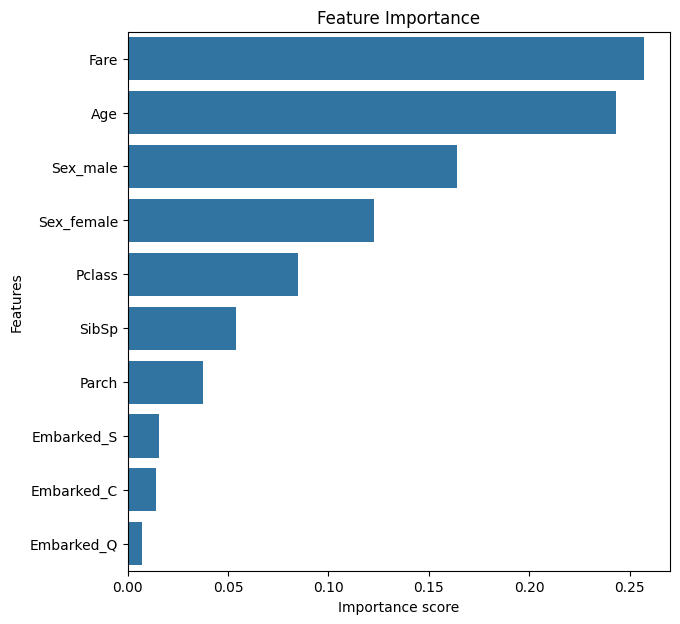

In [109]:
# Creating a seaborn bar plot
plt.figure(figsize=(7, 7))
sns.barplot(
    x=feature_imp_df["Importance"], y=feature_imp_df["Feature"], data=feature_imp_df
)
plt.title("Feature Importance")
plt.xlabel("Importance score")
plt.ylabel("Features")

As shown in the above graph, "Fare" feature contributes the most when predicting survival rate. 

### 3. Hyperparameter Tuning

In [110]:
# Define a base Random Forest model
rf = RandomForestClassifier(random_state=r)

# Hyperparameter tuning for Random Forest using GridSearchCV and fit the data.
from sklearn.model_selection import GridSearchCV

params = {
    "n_estimators": [10, 25, 30, 50, 100, 200],
    "max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["auto", "sqrt", "log2"],
}

# Instantiate the grid search model
grid_search = GridSearchCV(
    estimator=rf, param_grid=params, cv=3, n_jobs=-1, verbose=1, scoring="r2"
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 1458 candidates, totalling 4374 fits


C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
1458 fits failed out of a total of 4374.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
701 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-pa

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 25, 30, 50, 100, 200]},
             scoring='r2', verbose=1)

In [111]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=9, min_samples_leaf=4, n_estimators=10,
                       random_state=42)

In [112]:
print(grid_search.best_params_)
best_depth = grid_search.best_params_["max_depth"]
best_features = grid_search.best_params_["max_features"]
best_sample_leaf=grid_search.best_params_['min_samples_leaf']
best_sample_split=grid_search.best_params_['min_samples_split']
best_estimators = grid_search.best_params_["n_estimators"]

{'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 10}


### 4. Comparing Models (second time)

In [113]:
new_log = RandomForestClassifier(
    max_depth=best_depth,
    max_features=best_features,
    n_estimators=best_estimators,
    min_samples_leaf=best_sample_leaf,
    min_samples_split=best_sample_split,
    random_state=r,
)
new_log.fit(X_train, y_train)

new_accuracy1 = new_log.score(X_test, y_test)
data.append(["Random Forest with pre-pruning", new_accuracy1])

In [114]:
##featureimportance after tuning
# Get numerical feature importances
feature_names = X.columns
importances = new_log.feature_importances_

# Dataframe with features and importances, # Sort the feature importances by most important first
feature_imp_after_tuning_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": importances}
).sort_values("Importance", ascending=False)

feature_imp_after_tuning_df

,Feature,Importance
6,Sex_male,0.258051
5,Sex_female,0.237143
4,Fare,0.173115
1,Age,0.133286
0,Pclass,0.084367
2,SibSp,0.040246
9,Embarked_S,0.031507
3,Parch,0.022935
7,Embarked_C,0.014861
8,Embarked_Q,0.004490


Text(0, 0.5, 'Features')

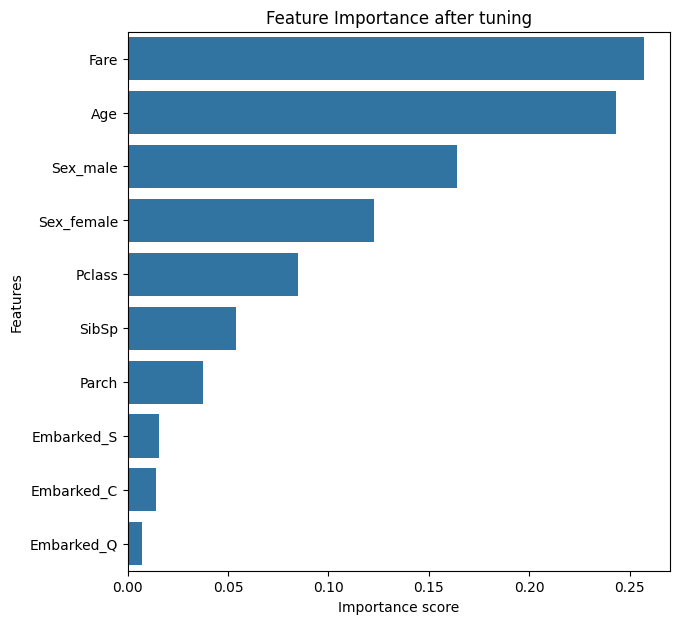

In [115]:
# Creating a seaborn bar plot
plt.figure(figsize=(7, 7))
sns.barplot(
    x=feature_imp_df["Importance"], y=feature_imp_df["Feature"], data=feature_imp_df
)
plt.title("Feature Importance after tuning")
plt.xlabel("Importance score")
plt.ylabel("Features")

### (Not part of task)
Accuracy after dropping least important feature according to Gini importance

In [116]:
[col for col in X.columns if 'Embarked' in col]

['Embarked_C', 'Embarked_Q', 'Embarked_S']

In [117]:
# drop the least important feature from X_train and X_test
drop_columns = ['Embarked_C', 'Embarked_Q', 'Embarked_S','Parch','SibSp']

X_train_gini = X_train.drop(drop_columns, axis=1)
X_test_gini = X_test.drop(drop_columns, axis=1)

# Create Random Forest Classifier

r = 42

new_log_gini = RandomForestClassifier(   
    max_depth=best_depth,
    max_features=best_features,
    n_estimators=best_estimators,
    min_samples_leaf=best_sample_leaf,
    min_samples_split=best_sample_split,
    random_state=r
    )
new_log_gini.fit(X_train_gini,y_train)

new_accuracy2 = new_log_gini.score(X_test_gini, y_test)
data.append(["Random Forest model with Gini importance", new_accuracy2])



In [119]:
from tabulate import tabulate

print(
    tabulate(
        data,
        headers=["Model", "Accuracy"],
        tablefmt="fancy_outline",
        colalign=("center",),
    )
)

print(f'The parameter of Random Forest with pre-pruning {grid_search.best_params_}.')

╒══════════════════════════════════════════╤════════════╕
│                  Model                   │   Accuracy │
╞══════════════════════════════════════════╪════════════╡
│              Decision Tree               │   0.826816 │
│               Bagged Tree                │   0.787709 │
│              Random Forest               │   0.810056 │
│      Random Forest with pre-pruning      │   0.798883 │
│ Random Forest model with Gini importance │   0.793296 │
╘══════════════════════════════════════════╧════════════╛
The parameter of Random Forest with pre-pruning {'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 10}.
